In [28]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
pip install matplotlib


                                              0.0/7.8 MB ? eta -:--:--
                                              0.1/7.8 MB 1.3 MB/s eta 0:00:06
                                              0.2/7.8 MB 2.3 MB/s eta 0:00:04
     --                                       0.4/7.8 MB 3.3 MB/s eta 0:00:03
     ---                                      0.6/7.8 MB 3.4 MB/s eta 0:00:03
     ----                                     0.9/7.8 MB 4.0 MB/s eta 0:00:02
     ------                                   1.3/7.8 MB 4.7 MB/s eta 0:00:02
     --------                                 1.6/7.8 MB 5.1 MB/s eta 0:00:02
     --------                                 1.7/7.8 MB 4.9 MB/s eta 0:00:02
     ----------                               2.0/7.8 MB 5.0 MB/s eta 0:00:02
     -----------                              2.2/7.8 MB 4.9 MB/s eta 0:00:02
     -----------                              2.2/7.8 MB 4.9 MB/s eta 0:00:02
     -----------                              2.2/7.8 MB 4.9 MB/s eta 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
pip install seaborn


                                              0.0/294.9 kB ? eta -:--:--
     --------                                61.4/294.9 kB 1.1 MB/s eta 0:00:01
     ----------------------                 174.1/294.9 kB 1.7 MB/s eta 0:00:01
     -----------------------------------    276.5/294.9 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
pip install scipy

                                              0.0/44.8 MB ? eta -:--:--
                                             0.0/44.8 MB 991.0 kB/s eta 0:00:46
                                              0.1/44.8 MB 1.4 MB/s eta 0:00:32
                                              0.2/44.8 MB 1.5 MB/s eta 0:00:30
                                              0.3/44.8 MB 1.6 MB/s eta 0:00:29
                                              0.4/44.8 MB 1.8 MB/s eta 0:00:25
                                              0.5/44.8 MB 1.9 MB/s eta 0:00:24
                                              0.7/44.8 MB 2.0 MB/s eta 0:00:22
                                              0.8/44.8 MB 2.1 MB/s eta 0:00:21
                                              0.9/44.8 MB 2.2 MB/s eta 0:00:20
                                              1.1/44.8 MB 2.3 MB/s eta 0:00:19
     -                                        1.3/44.8 MB 2.4 MB/s eta 0:00:18
     -                                        1.5/44.8 MB 


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt


In [5]:
df_SO2_perX = pd.read_csv('CSV_data\GEODAIR\O3\O3_moy_hor_per8.csv', sep = ';')

df_SO2_perX.describe()

,valeur,valeur brute,taux de saisie,couverture temporelle,couverture de données,validité,Latitude,Longitude
count,54915.000000,54915.000000,54915.000000,54915.0,54915.000000,54915.000000,54915.000000,54915.000000
mean,77.591960,77.578829,98.523300,100.0,98.523300,0.965437,43.921851,2.385489
std,24.053999,24.054031,7.440464,0.0,7.440464,0.260637,12.356722,14.251810
min,0.100000,0.100000,4.000000,100.0,4.000000,-1.000000,-21.334406,-63.081481
25%,64.300000,64.275000,100.000000,100.0,100.000000,1.000000,44.060347,1.047892
50%,75.700000,75.725000,100.000000,100.0,100.000000,1.000000,46.652668,3.058333
75%,89.300000,89.275000,100.000000,100.0,100.000000,1.000000,48.729694,5.394716
max,206.300000,206.275000,100.000000,100.0,100.000000,1.000000,51.032761,55.582620


### On combine les dataframes dans leur longueure

Les data frames sont chacuns divisisés en 8 périodes en raison des limitations liées à la méthode d'importation des données. On concatène donc les données liées à chaque polluant dans la longueur en procédant de la dernière période à la première (chaque période représentant une période de 6 mois classé dans l'odre antichronologique au sein de chaque data frame).

In [6]:
folder_paths = [
   r"CSV_data\GEODAIR\NO2\NO2_moy_hor_per", #Utiliser soit r"..." soit des \\ sinon les "\N" de "\NO2" posent problème
    "CSV_data\GEODAIR\O3\O3_moy_hor_per",
    "CSV_data\GEODAIR\PM2.5\PM2.5_moy_jour_per",
    "CSV_data\GEODAIR\PM10\PM10_moy_jour_per",
    "CSV_data\GEODAIR\SO2\SO2_moy_hor_per"
    ]

#Ici l'instruction "range(8,1,-1)" permet de classer les chemins du plus récent au moins récent.
all_file_paths = [[ folder + str(i) + ".csv" for i in range(8,0,-1)] for folder in folder_paths]


all_combined_df = [pd.concat([pd.read_csv(file, sep = ";") for file in all_file_paths[i]]) for i in range(5)]

longeurs = [len(df) for df in all_combined_df]
longeurs
#Fonctionne
# Output : [523418, 437621, 306241, 528658, 129022] le df le plus long est celui des mesures de NO2

[523418, 437621, 306241, 528658, 129022]

### Jointures

Pour calculer les indices de polluants localement, le plus simple est de joindre les data frames sur la clé suivante : [date, localisation]. On commence par joindre les différents dataframes sur le plus petits d'entre eux afin de maximiser la complétude des champs de données.

In [7]:
all_combined_df[3].head(2)


,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,...,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude
0,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,PM10,Fond,...,6.0,5.875000,µg-m3,100.0,100,100.0,A,1,49.119442,6.180833
1,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01012,Metz-Borny,Urbaine,PM10,Fond,...,7.0,6.645833,µg-m3,100.0,100,100.0,A,1,49.110283,6.223336


In [8]:

# On précise les colonnes sur lesquels on applique la jonction
join_columns = ["Date de début", "Date de fin", "code site"]

# On sélectionne le data frame avec le plus petit nombre de lignes
smallest_df = min(all_combined_df, key=len)

# On initialise avec les plus petit data frame
result_df = smallest_df

# On joint chaque dataframe de notre liste "all_combined_df" avec un suffixe unique
for i, df in enumerate(all_combined_df):
    if df is not smallest_df:  # pour éviter l'auto-jonction
        result_df = pd.merge(
            result_df, 
            df, 
            on=join_columns, 
            how='inner', 
            suffixes=(None, f'_df{i}')  # Un suffixe unique pour chaque data frame
        )

# result_df contient maintenant le inner join of de tous les data frames sur les colonnes spécifées


In [10]:
columns_list = result_df.columns.tolist()

print(columns_list, len(columns_list))
# Output :
['Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Polluant', "type d'influence", 'Réglementaire', "type d'évaluation", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure', 'taux de saisie', 'couverture temporelle', 'couverture de données', 'code qualité', 'validité', 'Latitude', 'Longitude',
 'Organisme_df0', 'code zas_df0', 'Zas_df0', 'nom site_df0', "type d'implantation_df0", 'Polluant_df0', "type d'influence_df0", 'Réglementaire_df0', "type d'évaluation_df0", 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0', 'taux de saisie_df0', 'couverture temporelle_df0', 'couverture de données_df0', 'code qualité_df0', 'validité_df0', 'Latitude_df0', 'Longitude_df0',
 'Organisme_df1', 'code zas_df1', 'Zas_df1', 'nom site_df1', "type d'implantation_df1", 'Polluant_df1', "type d'influence_df1", 'Réglementaire_df1', "type d'évaluation_df1", 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1', 'taux de saisie_df1', 'couverture temporelle_df1', 'couverture de données_df1', 'code qualité_df1', 'validité_df1', 'Latitude_df1', 'Longitude_df1',
 'Organisme_df2', 'code zas_df2', 'Zas_df2', 'nom site_df2', "type d'implantation_df2", 'Polluant_df2', "type d'influence_df2", 'Réglementaire_df2', "type d'évaluation_df2", 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2', 'taux de saisie_df2', 'couverture temporelle_df2', 'couverture de données_df2', 'code qualité_df2', 'validité_df2', 'Latitude_df2', 'Longitude_df2',
 'Organisme_df3', 'code zas_df3', 'Zas_df3', 'nom site_df3', "type d'implantation_df3", 'Polluant_df3', "type d'influence_df3", 'Réglementaire_df3', "type d'évaluation_df3", 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3', 'taux de saisie_df3', 'couverture temporelle_df3', 'couverture de données_df3', 'code qualité_df3', 'validité_df3', 'Latitude_df3', 'Longitude_df3']
103
"""
On compte donc au total 103 colonnes, certaines sont peut-être redondantes, notamment les collones "lattitude" "longitude", "nom du site", "type d'implantation", et probablement les "code zas" ainsi que "zas"
Les valeurs les plus intéressantes sont donc les suivantes :

'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',"""

['Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Polluant', "type d'influence", 'Réglementaire', "type d'évaluation", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure', 'taux de saisie', 'couverture temporelle', 'couverture de données', 'code qualité', 'validité', 'Latitude', 'Longitude', 'Organisme_df0', 'code zas_df0', 'Zas_df0', 'nom site_df0', "type d'implantation_df0", 'Polluant_df0', "type d'influence_df0", 'Réglementaire_df0', "type d'évaluation_df0", 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0', 'taux de saisie_df0', 'couverture temporelle_df0', 'couverture de données_df0', 'code qualité_df0', 'validité_df0', 'Latitude_df0', 'Longitude_df0', 'Organisme_df1', 'code zas_df1', 'Zas_df1', 'nom site_df1', "type d'implantation_df1", 'Polluant_df1', "type d'influence_df1", 'Réglementaire_df1', "type d'évaluation_df1", 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'un

'\nOn compte donc au total 103 colonnes, certaines sont peut-être redondantes, notamment les collones "lattitude" "longitude", "nom du site", "type d\'implantation", et probablement les "code zas" ainsi que "zas"\nLes valeurs les plus intéressantes sont donc les suivantes :\n\n\'Date de début\', \'Date de fin\', \'Organisme\', \'code zas\', \'Zas\', \'code site\', \'nom site\', "type d\'implantation", \'Latitude\', \'Longitude\',\n\'Polluant\', "type d\'influence", \'type de valeur\', \'valeur\', \'valeur brute\', \'unité de mesure\',\'code qualité\', \'validité\',\n\'Polluant_df0\', \'type de valeur_df0\', \'valeur_df0\', \'valeur brute_df0\', \'unité de mesure_df0\',\'code qualité_df0\', \'validité_df0\',\n\'Polluant_df1\', \'type de valeur_df1\', \'valeur_df1\', \'valeur brute_df1\', \'unité de mesure_df1\',\'code qualité_df1\', \'validité_df1\',\n\'Polluant_df2\', \'type de valeur_df2\', \'valeur_df2\', \'valeur brute_df2\', \'unité de mesure_df2\',\'code qualité_df2\', \'validité_

#### Output : (classé par variable associées de chaque tableau)
<table>
    <tr> 
        <th> Premier df </th>
        <th> Deuxième df </th>
        <th> Troisième df </th>
        <th> Quatrième df </th>
        <th> Cinquième df </th>
    </tr>
    <tr>
        <td>'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Polluant', "type d'influence", 'Réglementaire', "type d'évaluation", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure', 'taux de saisie', 'couverture temporelle', 'couverture de données', 'code qualité', 'validité', 'Latitude', 'Longitude',</td>
        <td>'Organisme_df0', 'code zas_df0', 'Zas_df0', 'nom site_df0', "type d'implantation_df0", 'Polluant_df0', "type d'influence_df0", 'Réglementaire_df0', "type d'évaluation_df0", 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0', 'taux de saisie_df0', 'couverture temporelle_df0', 'couverture de données_df0', 'code qualité_df0', 'validité_df0', 'Latitude_df0', 'Longitude_df0',</td>
        <td>'Organisme_df1', 'code zas_df1', 'Zas_df1', 'nom site_df1', "type d'implantation_df1", 'Polluant_df1', "type d'influence_df1", 'Réglementaire_df1', "type d'évaluation_df1", 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1', 'taux de saisie_df1', 'couverture temporelle_df1', 'couverture de données_df1', 'code qualité_df1', 'validité_df1', 'Latitude_df1', 'Longitude_df1',</td>
        <td>'Organisme_df2', 'code zas_df2', 'Zas_df2', 'nom site_df2', "type d'implantation_df2", 'Polluant_df2', "type d'influence_df2", 'Réglementaire_df2', "type d'évaluation_df2", 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2', 'taux de saisie_df2', 'couverture temporelle_df2', 'couverture de données_df2', 'code qualité_df2', 'validité_df2', 'Latitude_df2', 'Longitude_df2',</td>
        <td>'Organisme_df3', 'code zas_df3', 'Zas_df3', 'nom site_df3', "type d'implantation_df3", 'Polluant_df3', "type d'influence_df3", 'Réglementaire_df3', "type d'évaluation_df3", 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3', 'taux de saisie_df3', 'couverture temporelle_df3', 'couverture de données_df3', 'code qualité_df3', 'validité_df3', 'Latitude_df3', 'Longitude_df3'</td>
    </tr>
</table>

On compte donc au total 103 colonnes, certaines sont peut-être redondantes, notamment les collones "lattitude" "longitude", "nom du site", "type d'implantation", et probablement les "code zas" ainsi que "zas"
Les valeurs les plus intéressantes sont donc les suivantes :
<table>
    <tr> 
        <th> Variables communes </th>
        <th> Premier df (S02)</th>
        <th> Deuxième df (NO2)</th>
        <th> Troisième df (O3)</th>
        <th> Quatrième df (PM2.5)</th>
        <th> Cinquième df (PM10)</th>
    </tr>
    <tr>
        <td>'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',</td>
        <td>'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',</td>
        <td>'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',</td>
        <td>'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',</td>
        <td>'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',</td>
        <td>'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',</td>
    </tr>
</table>

In [11]:
# On vérifie à quel polluant est associé chaque famille de colonnes
result_df[['Polluant','Polluant_df0','Polluant_df1','Polluant_df2','Polluant_df3']].head(1)

,Polluant,Polluant_df0,Polluant_df1,Polluant_df2,Polluant_df3
0,SO2,NO2,O3,PM2.5,PM10


In [17]:
# Soit la liste des variables les plus utiles, on peut l'utiliser pour extraire un version synthétique du de result_df
best_variables = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
    'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
    'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
    'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
    'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
    'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',
]

best_df = result_df[best_variables]
best_df.sample(10)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,unité de mesure_df2,code qualité_df2,validité_df2,Polluant_df3,type de valeur_df3,valeur_df3,valeur brute_df3,unité de mesure_df3,code qualité_df3,validité_df3
5306,2023/06/22 00:00:00,2023/06/22 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,µg-m3,A,1,PM10,Moy. journalière,9.0,8.775000,µg-m3,A,1
4567,2023/05/06 00:00:00,2023/05/06 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.000000,µg-m3,A,1
6202,2022/08/20 00:00:00,2022/08/20 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,6.0,5.937500,µg-m3,A,1
9970,2022/05/12 00:00:00,2022/05/12 23:59:59,ATMO NOUVELLE-AQUITAINE,FR75ZAG01,ZAG BORDEAUX,FR31007,BASSENS,Urbaine,44.900296,-0.515835,...,µg-m3,A,1,PM10,Moy. journalière,12.0,12.095833,µg-m3,A,1
13524,2021/01/08 00:00:00,2021/01/08 23:59:59,ATMO AUVERGNE-RHÔNE-ALPES,FR84ZRE01,ZR AUVERGNE-RHONE-ALPES,FR33302,St Germain/Rhône,Rurale près des villes,46.072224,5.820833,...,µg-m3,A,1,PM10,Moy. journalière,20.0,19.537500,µg-m3,A,1
5498,2022/07/01 00:00:00,2022/07/01 23:59:59,QUALITAIR CORSE,FR94ZAR01,ZAR AJACCIO,FR41001,AJACCIO CANETTO,Urbaine,41.924694,8.735694,...,µg-m3,A,1,PM10,Moy. journalière,15.0,15.233333,µg-m3,A,1
7458,2022/11/16 00:00:00,2022/11/16 23:59:59,ATMO NOUVELLE-AQUITAINE,FR75ZAG01,ZAG BORDEAUX,FR31007,BASSENS,Urbaine,44.900296,-0.515835,...,µg-m3,A,1,PM10,Moy. journalière,13.0,12.533333,µg-m3,A,1
19047,2020/02/21 00:00:00,2020/02/21 23:59:59,ATMO REUNION,FR04ZAR02,ZAR VOLCAN,FR38011,Station Luther King,Urbaine,-21.334406,55.459060,...,µg-m3,A,1,PM10,Moy. journalière,15.0,15.383333,µg-m3,A,1
10982,2021/07/20 00:00:00,2021/07/20 23:59:59,ATMO NORMANDIE,FR28ZAG01,ZAG ROUEN,FR25036,Espace du Palais,Urbaine,49.442358,1.093789,...,µg-m3,A,1,PM10,Moy. journalière,23.0,22.675000,µg-m3,A,1
1255,2023/09/17 00:00:00,2023/09/17 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,µg-m3,A,1,PM10,Moy. journalière,7.0,7.250000,µg-m3,A,1


In [ ]:
# On peut vérifier que l'on a aucune valeur manquante
missing_values = pd.DataFrame(best_df.isna().sum())
missing_values


In [18]:
# On définit une fonction pour renommer les colonnes
# Définir les colonnes qui doivent garder leur nom tel quel
columns_to_keep = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 
    'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude'
]

# Définir la fonction pour renommer les colonnes
def rename_columns(column_name):
    # Vérifier si la colonne doit conserver son nom
    if column_name in columns_to_keep:
        return column_name
    # Ajouter le suffixe "_SO2" pour les colonnes sans suffixe qui ne sont pas dans columns_to_keep
    elif not any(column_name.endswith(suffixe) for suffixe in ["_df0", "_df1", "_df2", "_df3"]):
        return f"{column_name}_SO2"
    # Remplacer les suffixes spécifiques
    elif column_name.endswith("_df0"):
        return column_name.replace("_df0", "_NO2")
    elif column_name.endswith("_df1"):
        return column_name.replace("_df1", "_O3")
    elif column_name.endswith("_df2"):
        return column_name.replace("_df2", "_PM2.5")
    elif column_name.endswith("_df3"):
        return column_name.replace("_df3", "_PM10")
    else:
        return column_name

best_df = best_df.rename(columns=rename_columns)
best_df.head(5)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,unité de mesure_PM2.5,code qualité_PM2.5,validité_PM2.5,Polluant_PM10,type de valeur_PM10,valeur_PM10,valeur brute_PM10,unité de mesure_PM10,code qualité_PM10,validité_PM10
0,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
1,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
2,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
3,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
4,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,µg-m3,A,1,PM10,Moy. journalière,20.0,20.391667,µg-m3,A,1


In [19]:
from indice_atmo import *

In [40]:
best_df['iqa'] = best_df[["valeur_SO2","valeur_O3","valeur_NO2","valeur_PM2.5","valeur_PM10"]].apply(iqa, axis = 1)
best_df['atmo'] = best_df[["valeur_SO2","valeur_O3","valeur_NO2","valeur_PM2.5","valeur_PM10"]].apply(atmo, axis = 1)
best_df[['iqa','atmo']].head(5)

c:\Users\antoi\.vscode\Projet-data-science-Mornand-Merienne\indice_atmo.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valeurs_indice = [50*mesure_polluants_iqa[i]/valeurs_ref[i] for i in range(5)]
c:\Users\antoi\.vscode\Projet-data-science-Mornand-Merienne\indice_atmo.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if mesure_polluants[i] > tableau_ref[i][4] :
c:\Users\antoi\.vscode\Projet-data-science-Mornand-Merienne\indice_atmo.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame b

,iqa,atmo
0,111.714286,dégradé
1,111.714286,dégradé
2,111.714286,dégradé
3,111.714286,dégradé
4,142.714286,dégradé


<Axes: xlabel='atmo'>

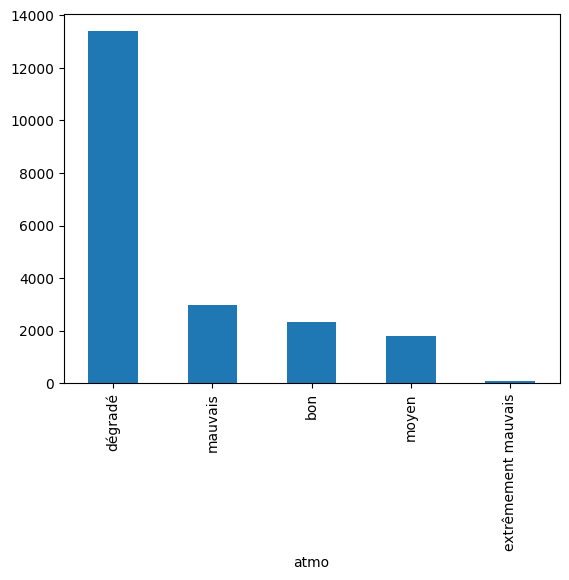

In [41]:
best_df["atmo"].value_counts().plot(kind = "bar")

<Axes: ylabel='Frequency'>

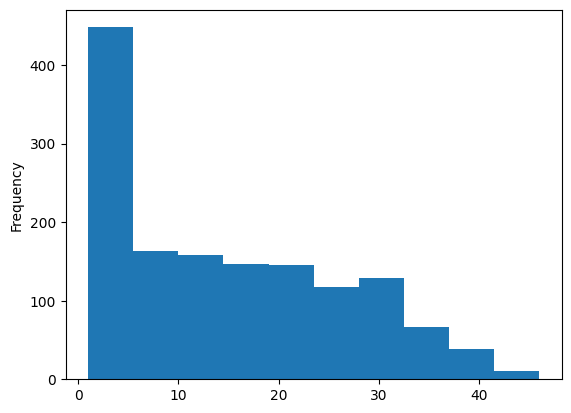

In [42]:
best_df["iqa"].value_counts().plot(kind = "hist", bins = 10)

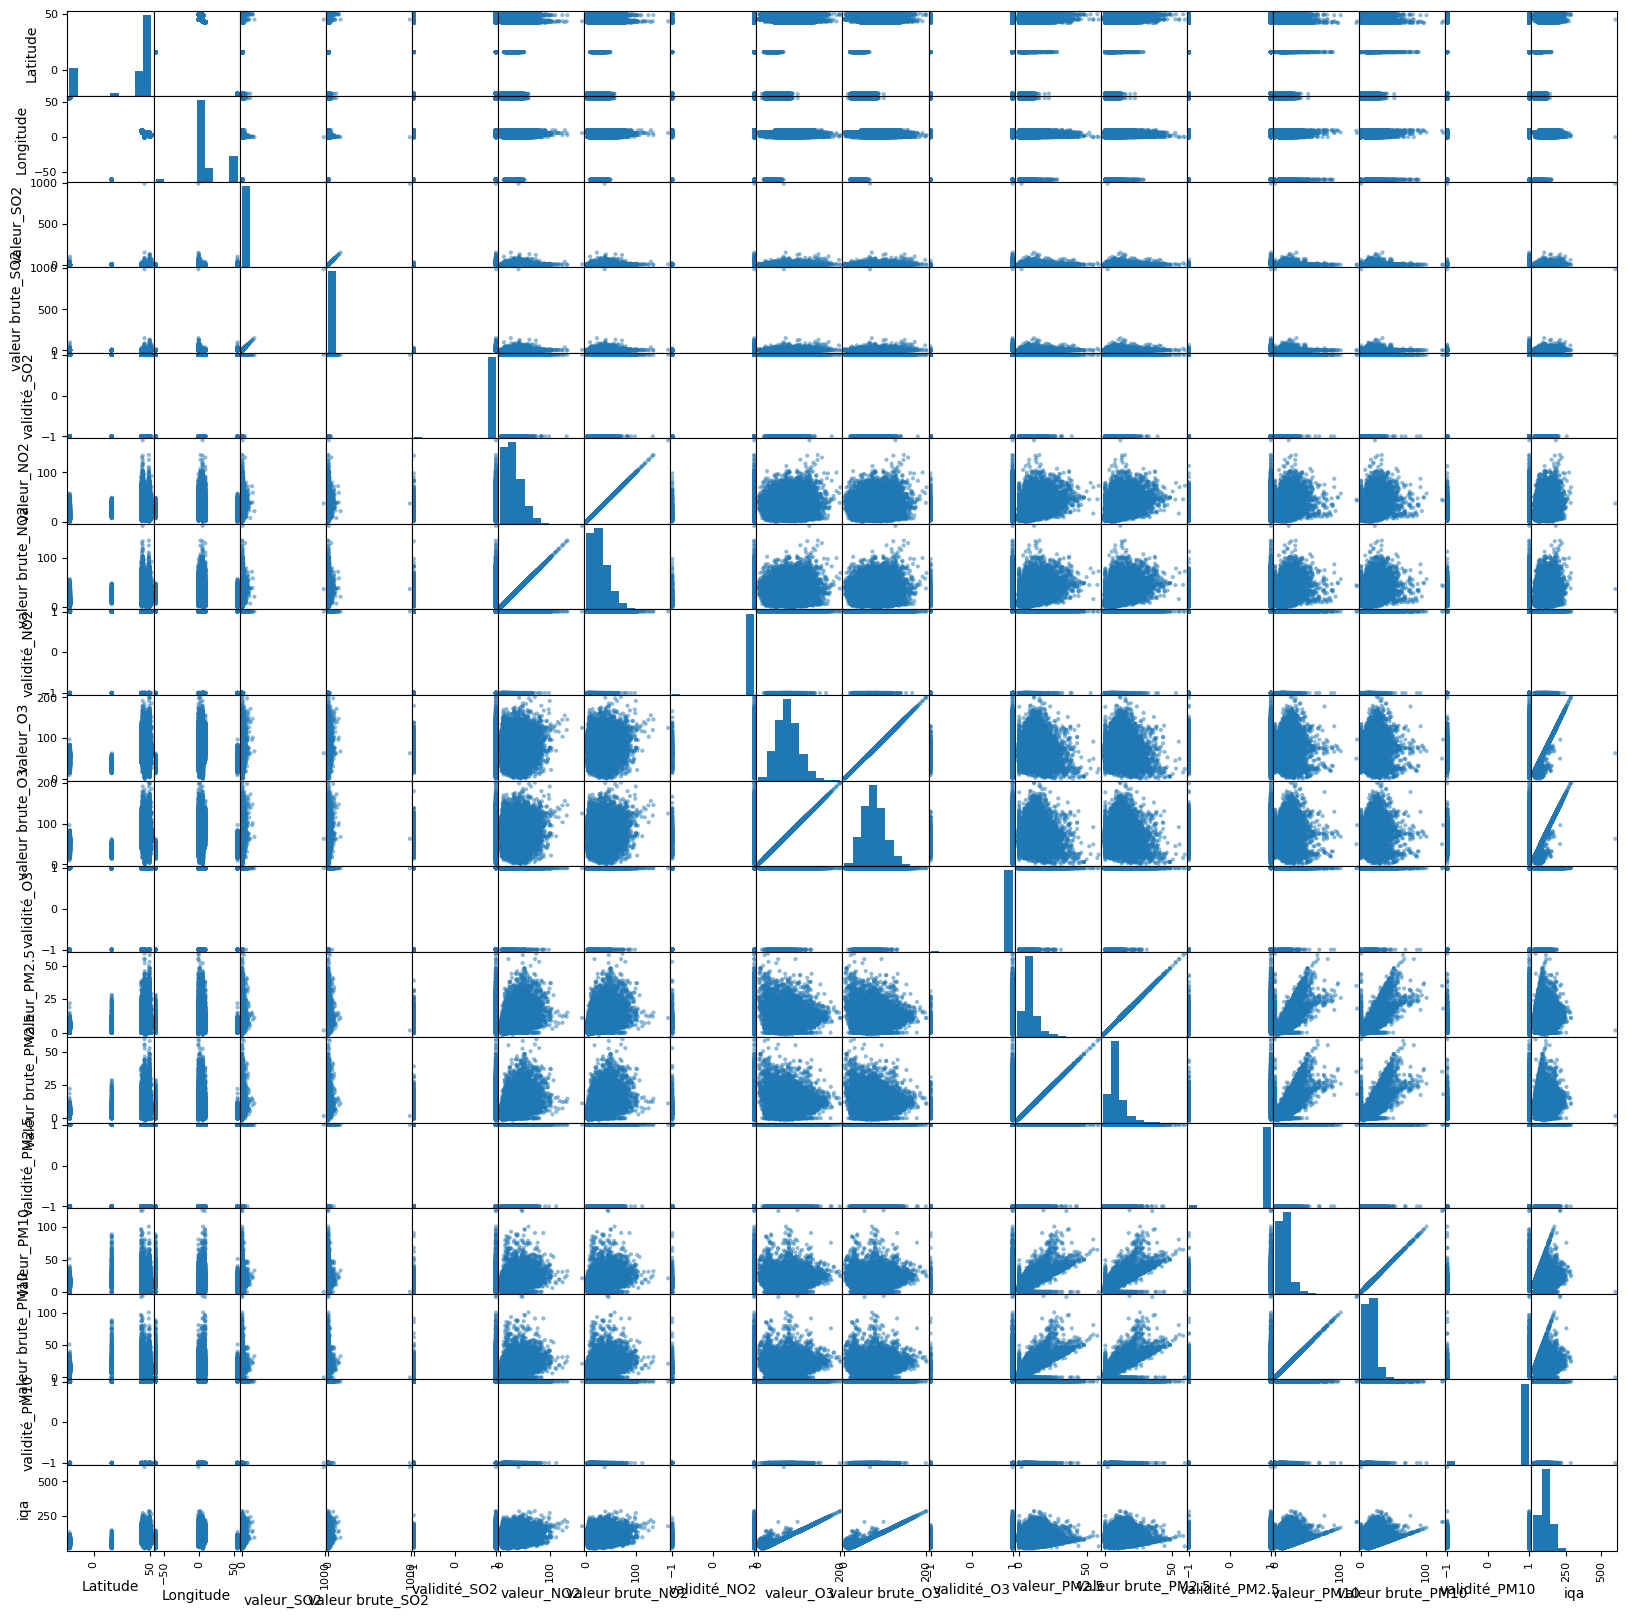

In [52]:
pd.plotting.scatter_matrix(best_df, figsize=(20, 20), diagonal='hist')  # Diagonal can be 'hist' or 'kde'
plt.show()

<Axes: xlabel='Longitude', ylabel='Latitude'>

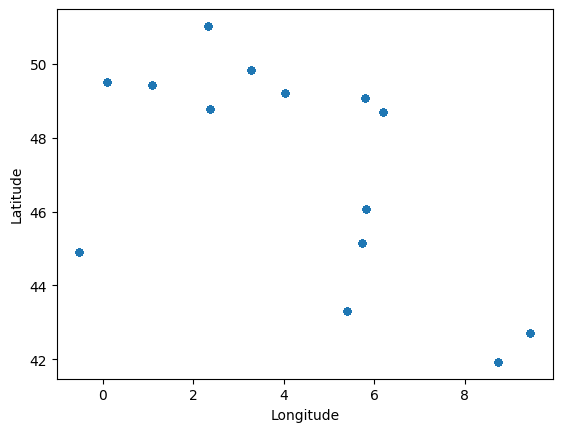

In [56]:
best_df[(best_df['Longitude'].abs()<20)].plot(kind = 'scatter', x = 'Longitude', y = 'Latitude')

### Problème
On ne compte que 14 points de mesure en métropole